In [20]:
import pandas as pd
import locale
import glob
import chardet
import numpy as np
import awswrangler as wr
import boto3

# AWS setup

In [21]:
boto3.setup_default_session(profile_name='patricio_ferreira_fellow_dssgx_24')

In [22]:
bucket = "dssgx-munich-2024-bavarian-forest"
raw_data_folder = "raw-data"
preprocessed_data_folder = "preprocessed_data"

# Load data

In [23]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.

    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.

    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """

    df = wr.s3.read_csv(path=path, **kwargs)
    return df


In [24]:
#2016 data had a higher number of columns, but we want to keep common columns for all visitor count data

def get_common_columns_across_historic_visitor_counts():
    df_2016 = load_csv_files_from_aws_s3("s3://dssgx-munich-2024-bavarian-forest/raw-data/hourly-historic-visitor-counts-all-sensors/visitor_counts_2016.csv", skiprows=2)



    historic_visitor_counts = load_csv_files_from_aws_s3(
    path=f"s3://{bucket}/{raw_data_folder}/hourly-historic-visitor-counts-all-sensors/export*.csv", skiprows=2)

    col_2016 = df_2016.columns
    col_export = historic_visitor_counts.columns

    common_cols = [col for col in col_2016 if col in col_export]
    
    return common_cols





In [25]:
historic_visitor_counts = load_csv_files_from_aws_s3(
    path=f"s3://{bucket}/{raw_data_folder}/hourly-historic-visitor-counts-all-sensors/*.csv",
    skiprows=2,
    usecols = get_common_columns_across_historic_visitor_counts()

)

historic_visitor_counts.shape

(75696, 96)

# Cleaning

### Format date

In [26]:
def parse_german_dates(
    df: pd.DataFrame,
    date_column_name: str
) -> pd.DataFrame:
    """
    Parses German dates in the specified date column of the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the date column.
        date_column_name (str): The name of the date column.

    Returns:
        pd.DataFrame: The DataFrame with parsed German dates.
    """
    
    # Set German locale
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")
    
    # Mapping of German month names to their English equivalents
    month_map = {
        "Jan.": "Jan",
        "Feb.": "Feb",
        "März": "Mar",
        "Apr.": "Apr",
        "Mai": "May",
        "Juni": "Jun",
        "Juli": "Jul",
        "Aug.": "Aug",
        "Sep.": "Sep",
        "Okt.": "Oct",
        "Nov.": "Nov",
        "Dez.": "Dec"
    }

    # Replace German month names with English equivalents
    for german, english in month_map.items():
        df[date_column_name] = df[date_column_name].str.replace(german, english)

    # Parse the dates
    df[date_column_name] = pd.to_datetime(df[date_column_name], format="mixed")

    return df

visitor_counts_parsed_dates = parse_german_dates(df=historic_visitor_counts, date_column_name="Time")

### Duplicated Indexes

In [27]:
#for some reason there are duplicated index

visitor_counts_parsed_dates.index.duplicated()

array([False, False, False, ..., False, False, False])

In [28]:
# reset the index to avoid future problems
visitor_counts_parsed_dates = visitor_counts_parsed_dates.reset_index(drop=True)

### Mapping

After reviewing all the columns to check for inconsistencies I arrived to a list of tasks that should be done to clean de dataset:

- Drop repeated columns listed in "to_drop". Waldhausreibe Channel 1 (IN and OUT) had a total sum of values of 10 and 13. Brechhäuslau columns were duplicated.
- Create "Bucina_Multi IN" as the sum of cyclist and pedestrians it's not there
- Rename columns that had wrong names


In [29]:
#lists an dictionaries to drop and rename

to_drop = ['Brechhäuslau Fußgänger IN', 'Brechhäuslau Fußgänger OUT', 'Waldhausreibe Channel 1 IN', 'Waldhausreibe Channel 2 OUT']

to_create = 'Bucina_Multi IN' #did not exist sum of pedestrian and cyclists for the MULTI sensor 


to_rename = {'Bucina IN': 'Bucina PYRO IN',
          'Bucina OUT': 'Bucina PYRO OUT',
          'Gsenget IN.1': 'Gsenget Fußgänger IN',
          'Gsenget OUT.1': 'Gsenget Fußgänger OUT',
          'Gfäll Fußgänger IN' : 'Gfäll IN',
          'Gfäll Fußgänger OUT': 'Gfäll OUT',
          'Fredenbrücke Fußgänger IN' : 'Fredenbrücke IN',
          'Fredenbrücke Fußgänger OUT': 'Fredenbrücke OUT',
          'Diensthüttenstraße Fußgänger IN': 'Diensthüttenstraße IN' ,
          'Diensthüttenstraße Fußgänger OUT': 'Diensthüttenstraße OUT',
          'Racheldiensthütte Cyclist OUT' : 'Racheldiensthütte Fahrräder OUT',
          'Racheldiensthütte Pedestrian IN' : 'Racheldiensthütte Fußgänger IN',
          'Racheldiensthütte Pedestrian OUT' : 'Racheldiensthütte Fußgänger OUT',
          'Sagwassersäge Fußgänger IN' : 'Sagwassersäge IN',
          'Sagwassersäge Fußgänger OUT': 'Sagwassersäge OUT',
          'Schwarzbachbrücke Fußgänger IN' : 'Schwarzbachbrücke IN',
          'Schwarzbachbrücke Fußgänger OUT' : 'Schwarzbachbrücke OUT',
          'NPZ_Falkenstein IN' : 'Falkenstein 1 PYRO IN',
          'NPZ_Falkenstein OUT' : 'Falkenstein 1 PYRO OUT',
          'TFG_Falkenstein_1 Fußgänger zum Parkplatz' : 'Falkenstein 1 OUT',
          'TFG_Falkenstein_1 Fußgänger zum HZW' : 'Falkenstein 1 IN',
          'TFG_Falkenstein_2 Fußgänger In Richtung Parkplatz' : 'Falkenstein 2 OUT',
          'TFG_Falkenstein_2 Fußgänger In Richtung TFG' : 'Falkenstein 2 IN',
          'TFG_Lusen IN' : 'Lusen 1 PYRO IN',
          'TFG_Lusen OUT' : 'Lusen 1 PYRO OUT',
          'TFG_Lusen_1 Fußgänger Richtung TFG': 'Lusen 1 EVO IN',
          'TFG_Lusen_1 Fußgänger Richtung Parkplatz' : 'Lusen 1 EVO OUT',
          'TFG_Lusen_2 Fußgänger Richtung Vögel am Waldrand': 'Lusen 2 IN',
          'TFG_Lusen_2 Fußgänger Richtung Parkplatz' : 'Lusen 2 OUT',
          'TFG_Lusen_3 TFG Lusen 3 IN': 'Lusen 3 IN',
          'TFG_Lusen_3 TFG Lusen 3 OUT': 'Lusen 3 OUT',
          'Waldspielgelände_1 IN': 'Waldspielgelände IN',
          'Waldspielgelände_1 OUT': 'Waldspielgelände OUT',
          'Wistlberg Fußgänger IN' : 'Wistlberg IN',
          'Wistlberg Fußgänger OUT' : 'Wistlberg OUT',
          'Trinkwassertalsperre IN' : 'Trinkwassertalsperre PYRO IN', 
          'Trinkwassertalsperre OUT' : 'Trinkwassertalsperre PYRO OUT'
          }

In [30]:
#Create copy of visitors_counts_parsed_dates
df = visitor_counts_parsed_dates

# Rename columns
df.rename(columns=to_rename, inplace=True)

# Drop columns
df.drop(columns=to_drop, inplace=True)

# Create Bucina Multi IN
df['Bucina_Multi IN'] = df["Bucina_Multi Fahrräder IN"] + df["Bucina_Multi Fußgänger IN"]

### Explore and analyze daylight saving time effect on data

In [31]:
# Check gap between entries: Every jump should be of one hour, but we can see in the print before that there are 7 gaps of 2hs and 7 of 0hs

df.sort_values("Time", ascending=True, inplace=True)

intervals = df.Time.diff().dropna()

intervals.value_counts()

Time
0 days 01:00:00    75677
0 days 02:00:00        9
0 days 00:00:00        9
Name: count, dtype: int64

In [32]:

# Find the first interval to use as a reference
reference_interval = intervals.iloc[0]

# Check where the intervals differ from the reference interval
different_intervals = intervals[intervals != reference_interval]

print("Intervals that differ from the reference interval:")
different_intervals

Intervals that differ from the reference interval:


63410   0 days 02:00:00
63411   0 days 00:00:00
54602   0 days 02:00:00
54603   0 days 00:00:00
1994    0 days 02:00:00
1995    0 days 00:00:00
10898   0 days 02:00:00
10899   0 days 00:00:00
19634   0 days 02:00:00
19635   0 days 00:00:00
28371   0 days 02:00:00
28370   0 days 00:00:00
37106   0 days 02:00:00
37107   0 days 00:00:00
45842   0 days 02:00:00
45843   0 days 00:00:00
72291   0 days 02:00:00
72290   0 days 00:00:00
Name: Time, dtype: timedelta64[ns]

While checking the rows we discovered that these rows are the only that have NaN values for all columns

In [33]:
pd.set_option('display.max_columns', None)
df[df.loc[:, df.columns != "Time"].isna().all(axis=1)]

Time  Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
61344 2016-01-01 00:00:00                      NaN                       NaN   
61345 2016-01-01 01:00:00                      NaN                       NaN   
61346 2016-01-01 02:00:00                      NaN                       NaN   
61347 2016-01-01 03:00:00                      NaN                       NaN   
61348 2016-01-01 04:00:00                      NaN                       NaN   
...                   ...                      ...                       ...   
19634 2020-03-29 03:00:00                      NaN                       NaN   
28370 2021-03-28 03:00:00                      NaN                       NaN   
37106 2022-03-27 03:00:00                      NaN                       NaN   
45842 2023-03-26 03:00:00                      NaN                       NaN   
72290 2024-03-31 03:00:00                      NaN                       NaN   

       Bayerisch Eisenstein Fußgänger IN  Bayerisch Eisenstein Fußgänger OUT  \
61344                                NaN                                 NaN   
61345                                NaN                                 NaN   
61346                                NaN                                 NaN   
61347                                NaN                                 NaN   
61348                                NaN                                 NaN   
...                                  ...                                 ...   
19634                                NaN                                 NaN   
28370                                NaN                                 NaN   
37106                                NaN                                 NaN   
45842                                NaN                                 NaN   
72290                                NaN                                 NaN   

       Bayerisch Eisenstein Fahrräder IN  Bayerisch Eisenstein Fahrräder OUT  \
61344                                NaN                                 NaN   
61345                                NaN                                 NaN   
61346                                NaN                                 NaN   
61347                                NaN                                 NaN   
61348                                NaN                                 NaN   
...                                  ...                                 ...   
19634                                NaN                                 NaN   
28370                                NaN                                 NaN   
37106                                NaN                                 NaN   
45842                                NaN                                 NaN   
72290                                NaN                                 NaN   

       Brechhäuslau IN  Brechhäuslau OUT  Bucina PYRO IN  Bucina PYRO OUT  \
61344              NaN               NaN             NaN              NaN   
61345              NaN               NaN             NaN              NaN   
61346              NaN               NaN             NaN              NaN   
61347              NaN               NaN             NaN              NaN   
61348              NaN               NaN             NaN              NaN   
...                ...               ...             ...              ...   
19634              NaN               NaN             NaN              NaN   
28370              NaN               NaN             NaN              NaN   
37106              NaN               NaN             NaN              NaN   
45842              NaN               NaN             NaN              NaN   
72290              NaN               NaN             NaN              NaN   

       Bucina_Multi OUT  Bucina_Multi Fußgänger IN  Bucina_Multi Fahrräder IN  \
61344               NaN                        NaN                        NaN   
61345               NaN                        NaN 

In [34]:
print("Example of problem: At the end of march every year skips a line")
print(df[["Time", "Bucina_Multi IN"]][1992: ].head(5))

Example of problem: At the end of march every year skips a line
                     Time  Bucina_Multi IN
63336 2016-03-24 00:00:00              NaN
63337 2016-03-24 01:00:00              NaN
63338 2016-03-24 02:00:00              NaN
63339 2016-03-24 03:00:00              NaN
63340 2016-03-24 04:00:00              NaN


We decided to change every repeated row to fill the "02:00" missing, and imputate that row with the values from the inmediately preceading row

In [35]:
index_wrong_time =different_intervals[different_intervals == "0 days 02:00:00"].index

# impute values from the next row
for idx in index_wrong_time:
    df.loc[idx, 'Time'] = df.loc[idx, 'Time'] - pd.Timedelta(hours=1) # sustract one hour to deal with summer daylight savings
    df.loc[idx, df.columns != 'Time'] = df.loc[idx + 1, df.columns != 'Time'] #impute the values from the 03:00 am hourly slot

Now for further work we can set the Time column as index

In [36]:
df = df.set_index('Time').sort_index()

### Problems with overlaping data

Some sensors have data when they should not. For example Bucina_Multi replaced Bucina PYRO, so when the records for Multi starts, PYRO should be all NaN.

In [37]:
# dict of non replaced sensors that have wrong data

dict_non_replaced = {'2020-07-30 00:00:00' : ['Lusen 1 PYRO IN', 'Lusen 1 PYRO OUT'],
                     '2022-12-20 00:00:00' : ['Lusen 3 IN', 'Lusen 3 OUT'],
                     '2022-10-12 00:00:00' : ['Gsenget IN', 'Gsenget OUT']}

for key, columns in dict_non_replaced.items():
    timestamp = pd.to_datetime(key)  # Convert the key to a datetime object
    # Set the values to NaN for the specified columns where the index is earlier than the timestamp
    df.loc[df.index < timestamp, columns] = np.nan

In [38]:
#dict of replaced sensors variables

merge = {'Bucina MERGED IN' : ['Bucina PYRO IN', 'Bucina_Multi IN'],
        'Bucina MERGED OUT' : ['Bucina PYRO OUT', 'Bucina_Multi OUT'],
        'Falkenstein 1 MERGED IN': ['Falkenstein 1 PYRO IN', 'Falkenstein 1 IN'],
        'Falkenstein 1 MERGED OUT':['Falkenstein 1 PYRO OUT', 'Falkenstein 1 OUT'],
        'Lusen 1 MERGED IN':['Lusen 1 PYRO IN', 'Lusen 1 EVO IN'],
        'Lusen 1 MERGED OUT':['Lusen 1 PYRO OUT', 'Lusen 1 EVO OUT'],
        'Trinkwassertalsperre MERGED IN':['Trinkwassertalsperre PYRO IN', 'Trinkwassertalsperre_MULTI IN'],
        'Trinkwassertalsperre MERGED OUT':['Trinkwassertalsperre PYRO OUT', 'Trinkwassertalsperre_MULTI OUT'] 
        }

In [39]:
def check_column_overlap(dataframe, columns_dict):

    """Function to check if some selected columns (the ones that have replaced sensors) have overlapping records"""
    
    for key, columns in columns_dict.items():
        if len(columns) != 2:
            print(f"Error: The value for key '{key}' does not contain exactly two columns.")
            continue
        
        col1, col2 = columns
        
        # Ensure columns exist in the dataframe
        if col1 in dataframe.columns and col2 in dataframe.columns:
            # Check for overlapping non-NaN values
            overlap = (~dataframe[col1].isna()) & (~dataframe[col2].isna())
            if overlap.any():
                print(f"Overlap found in columns: {col1} and {col2}")
            else:
                print(f"No overlap in columns: {col1} and {col2}")
        else:
            print(f"Columns {col1} or {col2} not found in the dataframe")

check_column_overlap(df, merge)

Overlap found in columns: Bucina PYRO IN and Bucina_Multi IN
Overlap found in columns: Bucina PYRO OUT and Bucina_Multi OUT
Overlap found in columns: Falkenstein 1 PYRO IN and Falkenstein 1 IN
Overlap found in columns: Falkenstein 1 PYRO OUT and Falkenstein 1 OUT
No overlap in columns: Lusen 1 PYRO IN and Lusen 1 EVO IN
No overlap in columns: Lusen 1 PYRO OUT and Lusen 1 EVO OUT
Overlap found in columns: Trinkwassertalsperre PYRO IN and Trinkwassertalsperre_MULTI IN
Overlap found in columns: Trinkwassertalsperre PYRO OUT and Trinkwassertalsperre_MULTI OUT


Find the index for when the overlaps start

In [40]:
def find_first_overlap_index(dataframe, columns_dict):
    overlap_indices = {}
    
    for key, columns in columns_dict.items():
        col1, col2 = columns
        
        # Ensure columns exist in the dataframe
        if col1 in dataframe.columns and col2 in dataframe.columns:
            # Check for overlapping non-NaN values
            overlap = (~dataframe[col1].isna()) & (~dataframe[col2].isna())
            if overlap.any():
                first_overlap_index = overlap.idxmax()  # idxmax() returns the first index where condition is True
                overlap_indices[key] = first_overlap_index
            else:
                overlap_indices[key] = None  # No overlap found
        else:
            overlap_indices[key] = None  # Columns not found
    
    return overlap_indices

find_first_overlap_index(df, merge)

{'Bucina MERGED IN': Timestamp('2021-05-28 00:00:00'),
 'Bucina MERGED OUT': Timestamp('2021-05-28 00:00:00'),
 'Falkenstein 1 MERGED IN': Timestamp('2022-12-22 12:00:00'),
 'Falkenstein 1 MERGED OUT': Timestamp('2022-12-22 12:00:00'),
 'Lusen 1 MERGED IN': None,
 'Lusen 1 MERGED OUT': None,
 'Trinkwassertalsperre MERGED IN': Timestamp('2016-05-09 00:00:00'),
 'Trinkwassertalsperre MERGED OUT': Timestamp('2016-05-09 00:00:00')}

Fix overlap for **Trinkwassertalsperre**

In [41]:
replacement_date = '2021-06-18 00:00:00'

multi_columns = ['Trinkwassertalsperre_MULTI Fußgänger IN',
                 'Trinkwassertalsperre_MULTI Fußgänger OUT',
                 'Trinkwassertalsperre_MULTI Fahrräder IN',
                 'Trinkwassertalsperre_MULTI Fahrräder OUT',
                 'Trinkwassertalsperre_MULTI IN',
                 'Trinkwassertalsperre_MULTI OUT'
                 ]

pyro_columns = ['Trinkwassertalsperre PYRO IN',
                'Trinkwassertalsperre PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

Fix overlap for **Bucina**

In [42]:
replacement_date = '2021-05-28 00:00:00'

multi_columns = ['Bucina_Multi OUT',
                 'Bucina_Multi Fußgänger IN', 'Bucina_Multi Fahrräder IN',
                 'Bucina_Multi Fahrräder OUT', 'Bucina_Multi Fußgänger OUT',
                 'Bucina_Multi IN'
                 ]

pyro_columns = ['Bucina PYRO IN', 'Bucina PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

Fix overlap for **Falkenstein 1**

In [43]:
replacement_date = '2022-12-22 12:00:00'

multi_columns = ['Falkenstein 1 OUT',
                 'Falkenstein 1 IN']

pyro_columns = ['Falkenstein 1 PYRO IN', 'Falkenstein 1 PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

**Final Check of Overlaps**

In [44]:
check_column_overlap(df, merge)

No overlap in columns: Bucina PYRO IN and Bucina_Multi IN
No overlap in columns: Bucina PYRO OUT and Bucina_Multi OUT
No overlap in columns: Falkenstein 1 PYRO IN and Falkenstein 1 IN
No overlap in columns: Falkenstein 1 PYRO OUT and Falkenstein 1 OUT
No overlap in columns: Lusen 1 PYRO IN and Lusen 1 EVO IN
No overlap in columns: Lusen 1 PYRO OUT and Lusen 1 EVO OUT
No overlap in columns: Trinkwassertalsperre PYRO IN and Trinkwassertalsperre_MULTI IN
No overlap in columns: Trinkwassertalsperre PYRO OUT and Trinkwassertalsperre_MULTI OUT


### Merge columns for same position

In [45]:
def merge_columns(df):
    """
    Merges columns from replaced sensors in the DataFrame into new combined columns based on a predefined mapping and drops the original columns after merging.

    The function merges multiple related columns into single combined columns using a predefined dictionary (`merge_dict`). 
    For each key-value pair in the dictionary, values from the first column are used, and missing values are filled 
    from the second column. After merging, the original columns used for merging are dropped from the DataFrame.

    Args:
        df (pandas.DataFrame): A DataFrame containing columns to be merged.

    Returns:
        pandas.DataFrame: The modified DataFrame with the new merged columns and original columns removed.
    """
    merge_dict = {
        'Bucina MERGED IN': ['Bucina PYRO IN', 'Bucina_Multi IN'],
        'Bucina MERGED OUT': ['Bucina PYRO OUT', 'Bucina_Multi OUT'],
        'Falkenstein 1 MERGED IN': ['Falkenstein 1 PYRO IN', 'Falkenstein 1 IN'],
        'Falkenstein 1 MERGED OUT': ['Falkenstein 1 PYRO OUT', 'Falkenstein 1 OUT'],
        'Lusen 1 MERGED IN': ['Lusen 1 PYRO IN', 'Lusen 1 EVO IN'],
        'Lusen 1 MERGED OUT': ['Lusen 1 PYRO OUT', 'Lusen 1 EVO OUT'],
        'Trinkwassertalsperre MERGED IN': ['Trinkwassertalsperre PYRO IN', 'Trinkwassertalsperre_MULTI IN'],
        'Trinkwassertalsperre MERGED OUT': ['Trinkwassertalsperre PYRO OUT', 'Trinkwassertalsperre_MULTI OUT']
    }

    # Iterate over each item in the dictionary to merge columns
    for new_col, cols in merge_dict.items():
        # Combine the two columns into one using the first non-null value
        df[new_col] = df[cols[0]].combine_first(df[cols[1]])

    # Drop the original columns used for merging
    cols_to_drop = [col for cols in merge_dict.values() for col in cols]
    df = df.drop(columns=cols_to_drop)

    return df

df = merge_columns(df)


### Check outliers

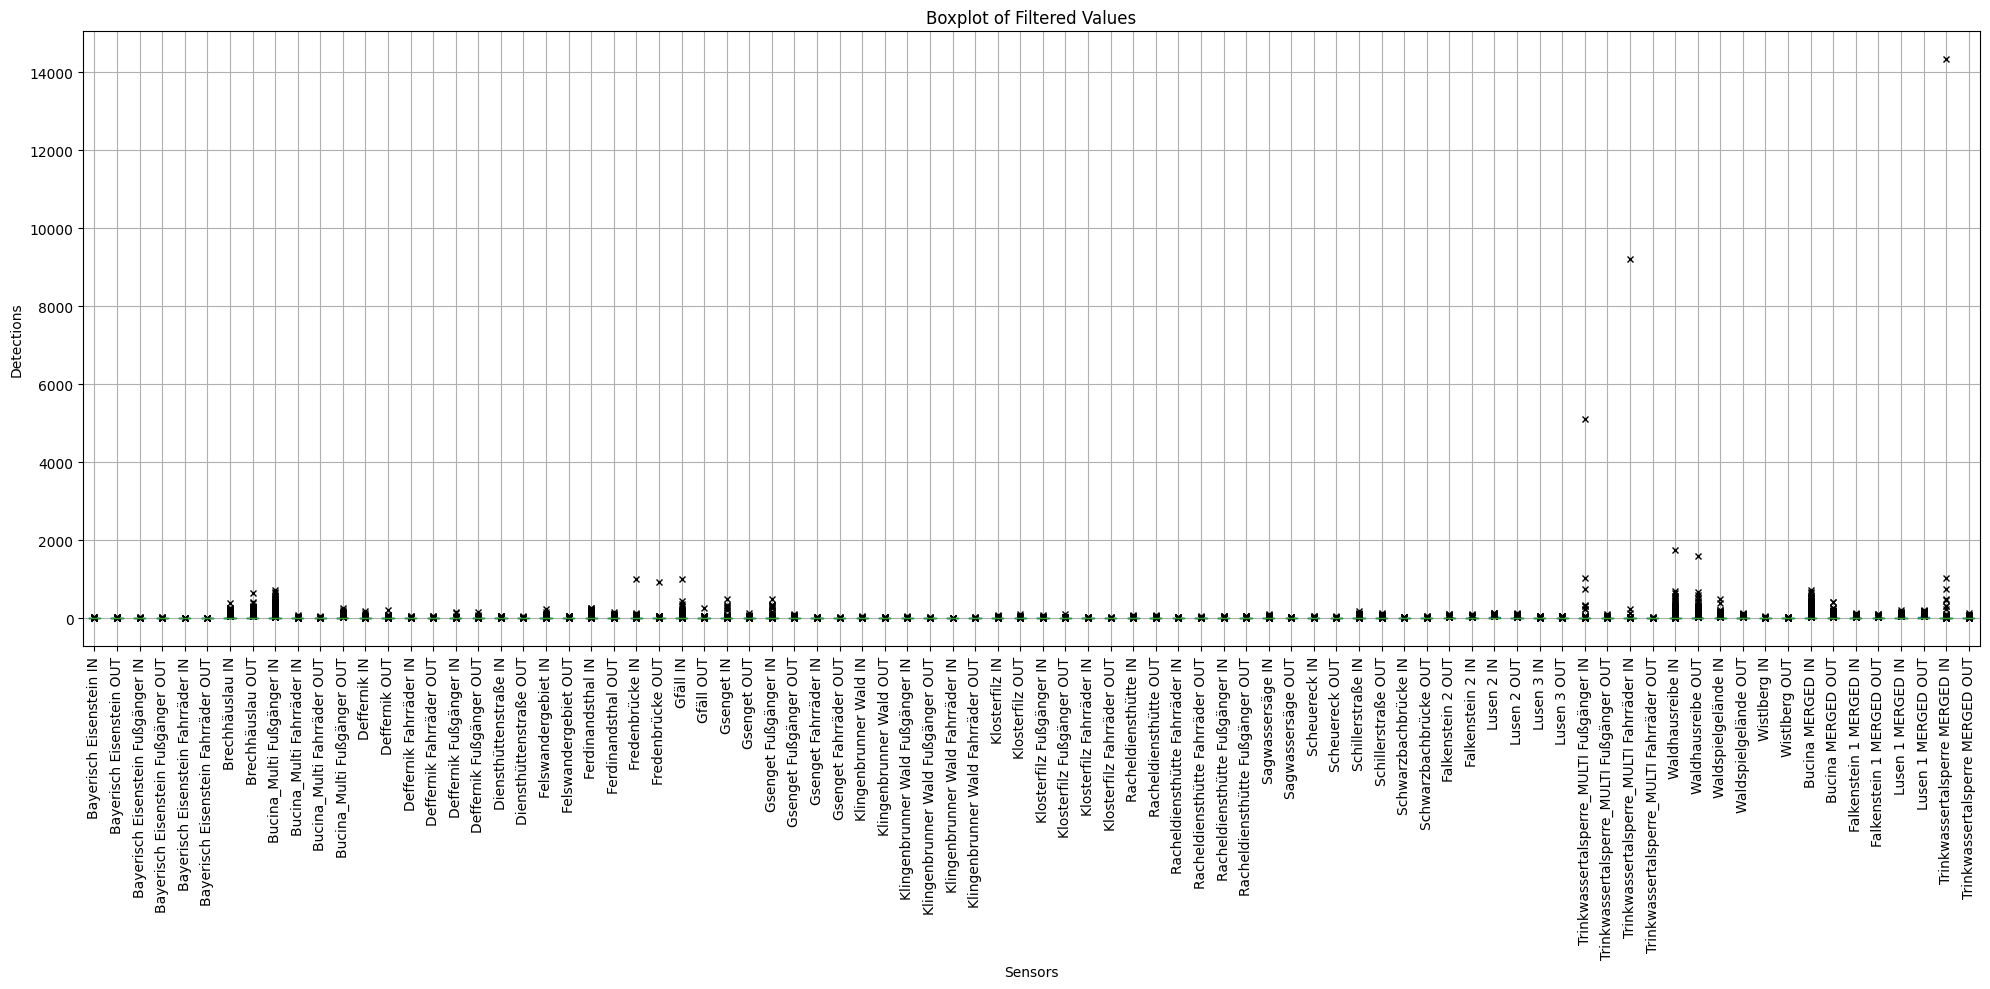

In [46]:
import matplotlib.pyplot as plt

# Replace zero values with NaN
df_filtered = df.replace(0, np.nan)

# Drop rows where all values are NaN (i.e., where all values were zero or greater than 1000)
df_filtered = df_filtered.dropna(how='all')

# Drop columns where all values are NaN (if any column became completely empty)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Check if there are any remaining columns to plot
if not df_filtered.empty and not df_filtered.select_dtypes(include=[np.number]).empty:
    plt.figure(figsize=(20, 10))
    
    # Create the boxplot
    boxplot = df_filtered.boxplot(
        whis=1.5,
        flierprops=dict(marker='x', color='red', markersize=5)
    )
    
    plt.title('Boxplot of Filtered Values')
    plt.xlabel('Sensors')
    plt.ylabel('Detections')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
else:
    print("No numeric columns available for plotting.")


Rows with count over 800

In [47]:
# Identify columns where any value exceeds 1000
high_value_columns = df.columns[(df > 800).any()]

df_high_value_columns = df[high_value_columns]
df_high_value_columns[df_high_value_columns > 800].dropna(how='all')


Fredenbrücke IN  Fredenbrücke OUT  Gfäll IN  \
Time                                                               
2017-12-31 00:00:00              NaN               NaN       NaN   
2021-02-04 09:00:00              NaN               NaN    1023.0   
2021-06-04 23:00:00           1011.0               NaN       NaN   
2021-06-06 05:00:00              NaN             944.0       NaN   
2022-05-07 10:00:00              NaN               NaN       NaN   
2022-05-08 11:00:00              NaN               NaN       NaN   

                     Trinkwassertalsperre_MULTI Fußgänger IN  \
Time                                                           
2017-12-31 00:00:00                                      NaN   
2021-02-04 09:00:00                                      NaN   
2021-06-04 23:00:00                                      NaN   
2021-06-06 05:00:00                                      NaN   
2022-05-07 10:00:00                                   5116.0   
2022-05-08 11:00:00                                   1040.0   

                     Trinkwassertalsperre_MULTI Fahrräder IN  \
Time                                                           
2017-12-31 00:00:00                                      NaN   
2021-02-04 09:00:00                                      NaN   
2021-06-04 23:00:00                                      NaN   
2021-06-06 05:00:00                                      NaN   
2022-05-07 10:00:00                                   9212.0   
2022-05-08 11:00:00                                      NaN   

                     Waldhausreibe IN  Waldhausreibe OUT  \
Time                                                       
2017-12-31 00:00:00            1752.0             1593.0   
2021-02-04 09:00:00               NaN                NaN   
2021-06-04 23:00:00               NaN                NaN   
2021-06-06 05:00:00               NaN                NaN   
2022-05-07 10:00:00               NaN                NaN   
2022-05-08 11:00:00               NaN                NaN   

                     Trinkwassertalsperre MERGED IN  
Time                                                 
2017-12-31 00:00:00                             NaN  
2021-02-04 09:00:00                             NaN  
2021-06-04 23:00:00                             NaN  
2021-06-06 05:00:00                             NaN  
2022-05-07 10:00:00                         14328.0  
2022-05-08 11:00:00                          1040.0

There are only 6 rows with values over 800, and they are isolated. We will replace them with NaN



In [48]:
df[df > 800] = np.nan

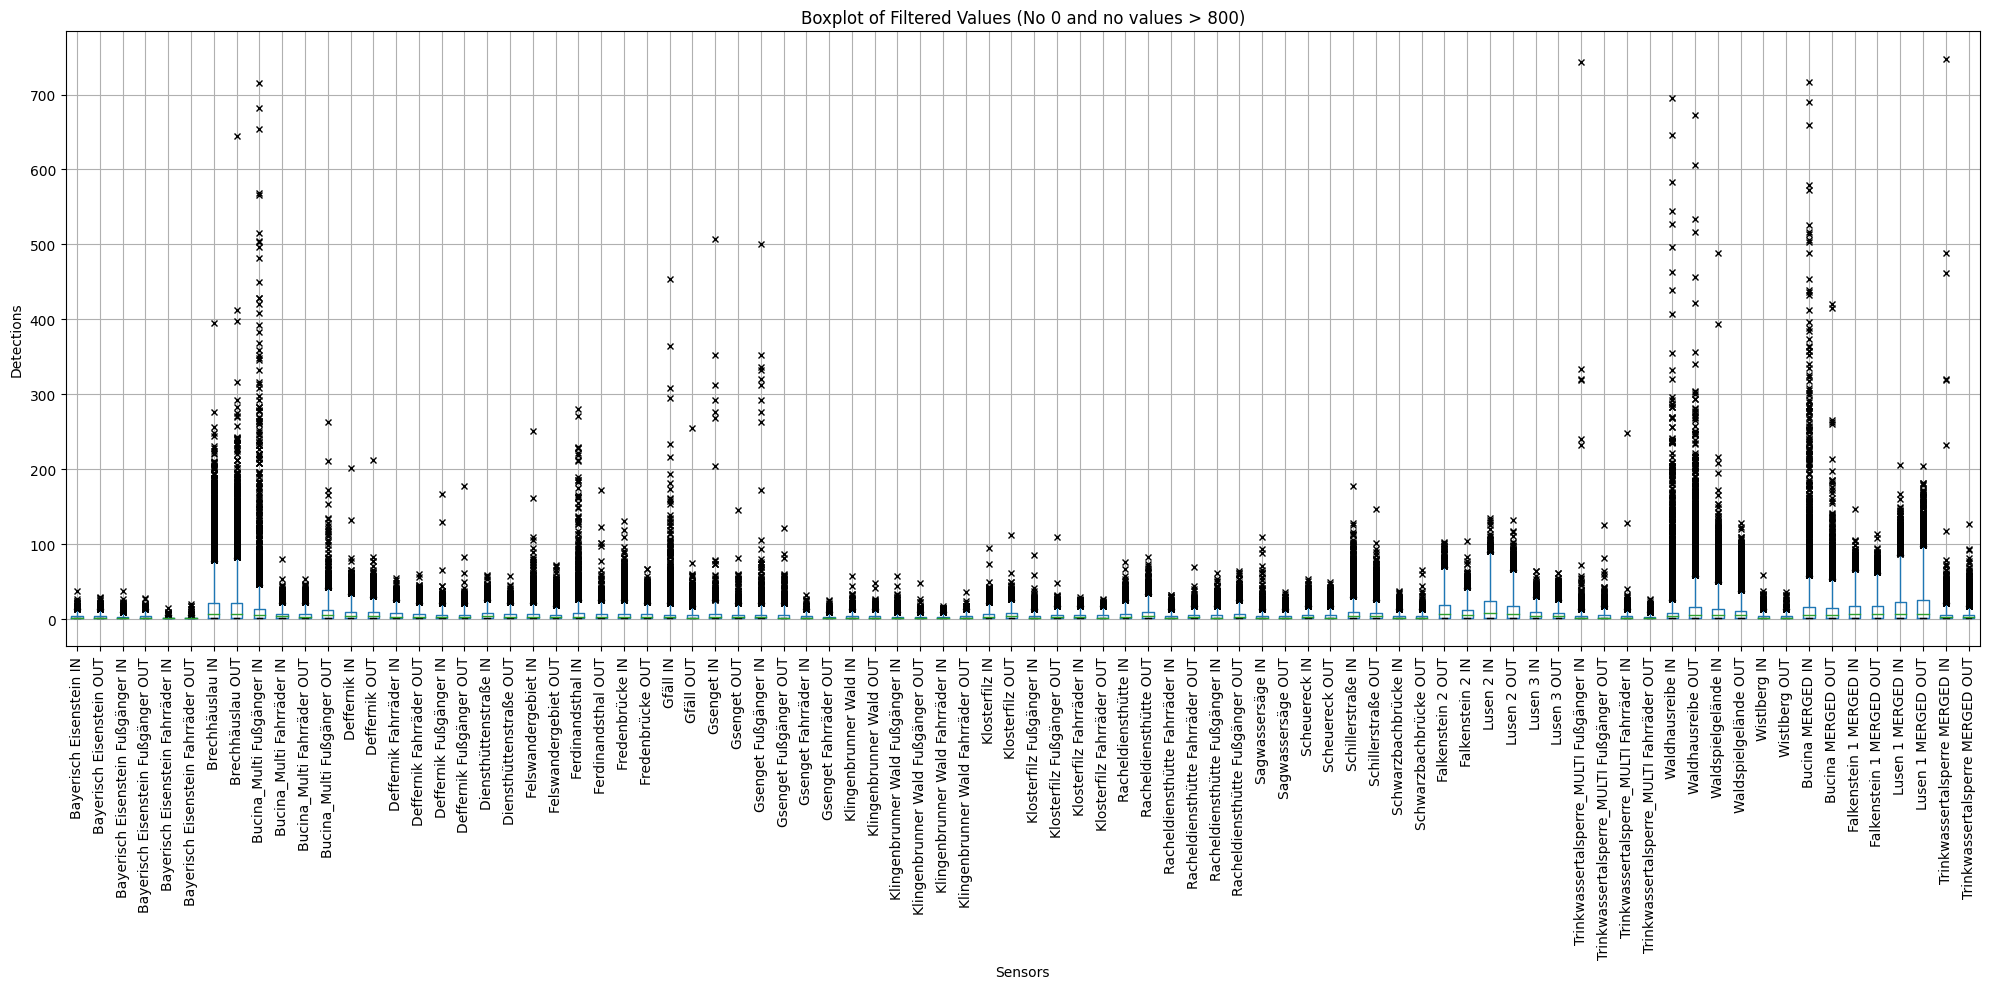

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is already defined earlier in your code

# Replace zero values with NaN to better visualize boxplots
df_filtered = df.replace(0, np.nan)

# Drop rows where all values are NaN (i.e., where all values were zero or greater than 1000)
df_filtered = df_filtered.dropna(how='all')

# Drop columns where all values are NaN (if any column became completely empty)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Check if there are any remaining columns to plot
if not df_filtered.empty and not df_filtered.select_dtypes(include=[np.number]).empty:
    plt.figure(figsize=(20, 10))
    
    # Create the boxplot
    boxplot = df_filtered.boxplot(
        whis=3,
        flierprops=dict(marker='x', color='red', markersize=5)
    )
    
    plt.title('Boxplot of Filtered Values (No 0 and no values > 800)')
    plt.xlabel('Sensors')
    plt.ylabel('Detections')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
else:
    print("No numeric columns available for plotting.")


### Overview of missing values

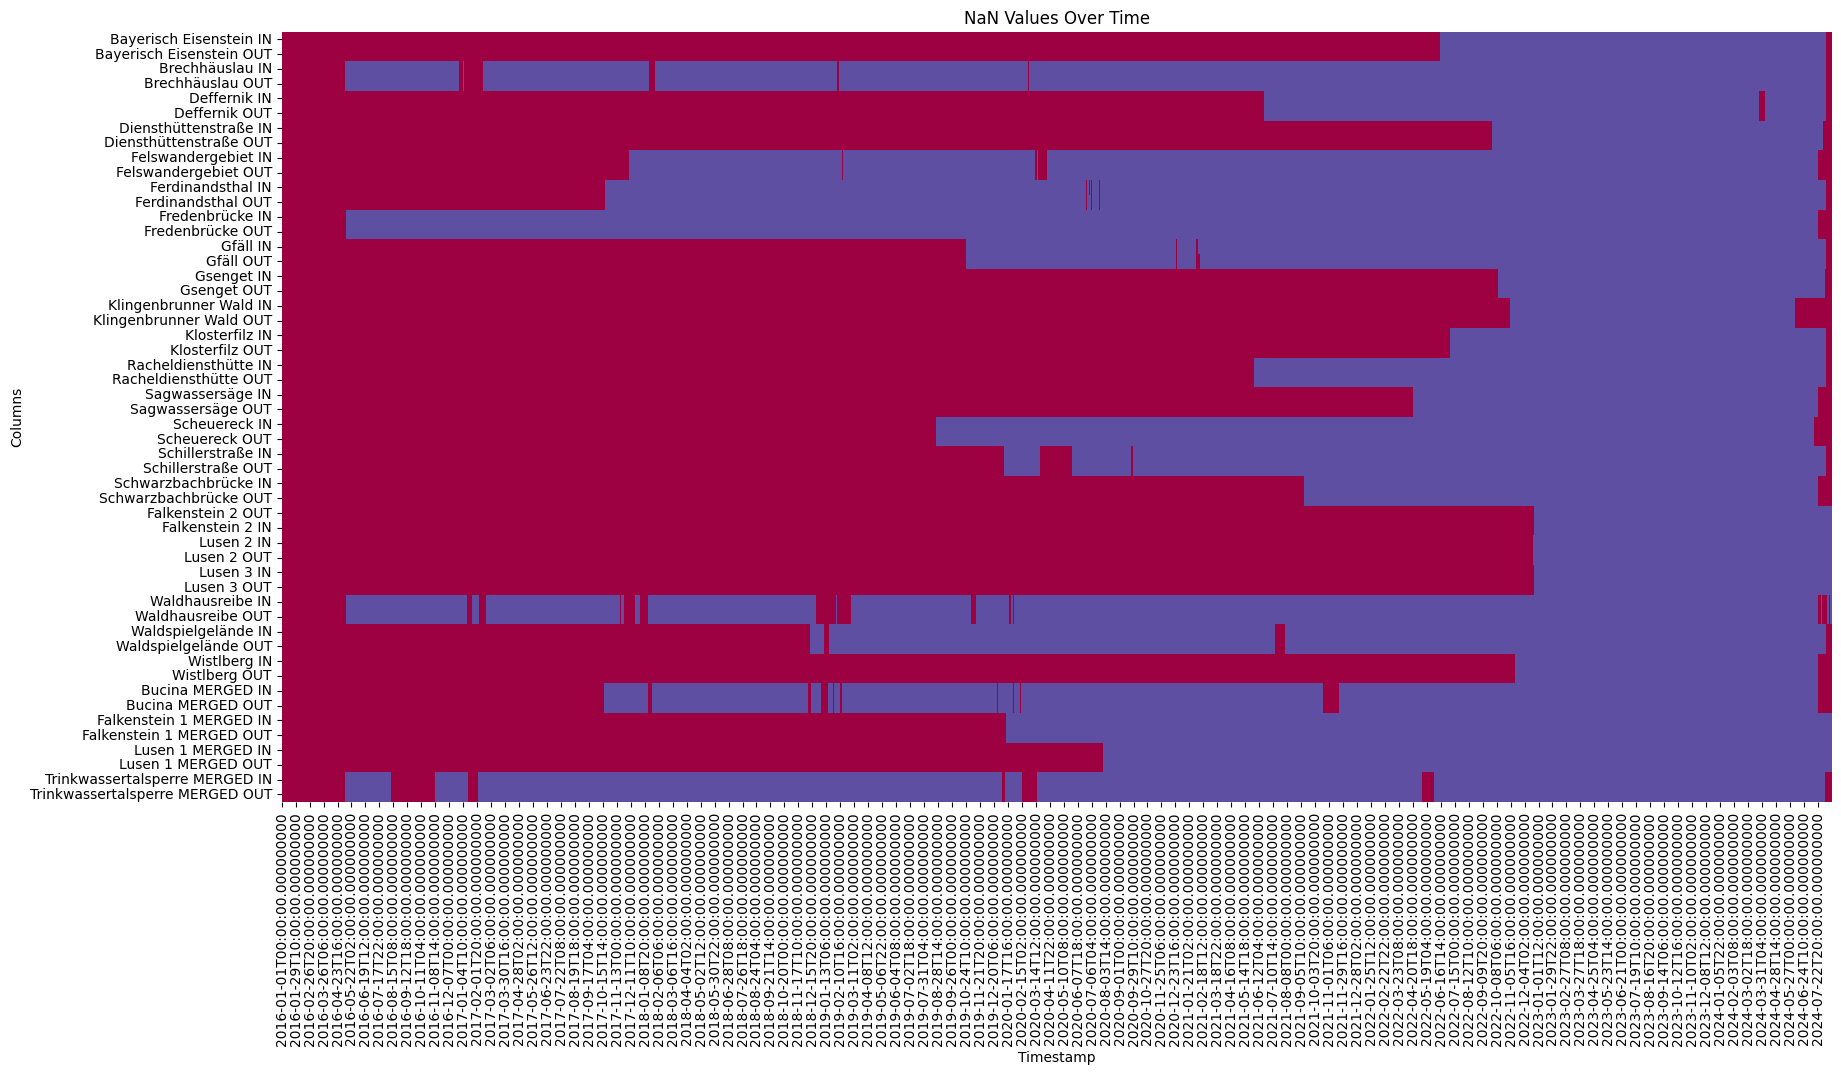

In [50]:
import seaborn as sns
# Create a DataFrame indicating NaN values (True if NaN, False otherwise)

traffic_columns = [col for col in df.columns 
                    if "Fahrräder" not in col 
                    and "Fußgänger" not in col]

traffic_columns = [col for col in traffic_columns 
                    if "Bucina" not in col 
                    and "Trinkwass" not in col
                    and "TFG" not in col
                    and "Lusen 1" not in col
                    and "Falkenstein 1" not in col]

keys_list = list(merge.keys())

for key in keys_list:
    traffic_columns.append(key)
 
traffic_IN = [col for col in traffic_columns if "IN" in col]

nan_df = df[traffic_columns].isna()

# Set up the plot
plt.figure(figsize=(20, 10))

# Plot the heatmap
sns.heatmap(nan_df.T, cmap='Spectral_r', cbar=False)

# Set axis labels
plt.xlabel('Timestamp')
plt.ylabel('Columns')
plt.title('NaN Values Over Time')

# Show the plot
plt.show()

# Create target variable for first iteration

- Create a column for the sum of IN and OUT, to have a general representation of traffic with no direction.
- Create another column sustracting from this the OUTS for the park entrances


### Traffic:
Sum of INS and OUTS

DROP NON MERGED COLUMNS

In [51]:
# discard cyclyst and pedestrians for first iteration
non_cyclist_pedestrian = [col for col in df.columns 
                    if "Fahrräder" not in col 
                    and "Fußgänger" not in col]
print(len(traffic_columns))

52


In [59]:
df_merged = df[traffic_columns]

### Only keep rows from 2016 after a sensor was installed and create working sensors variable

In [60]:
df_merged = df_merged[df_merged.index >= "2016-05-10 03:00:00"]

df_merged['working_sensors'] = df_merged[traffic_columns].notnull().sum(axis=1)

In [61]:
df_merged['is_odd'] = df_merged['working_sensors'] % 2 != 0

# Display rows where 'column_name' is odd
odd_numbers = df_merged[df_merged['is_odd']]
odd_numbers

Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
Time                                                                     
2020-07-01 00:00:00                      NaN                       NaN   
2020-07-01 01:00:00                      NaN                       NaN   
2020-07-01 02:00:00                      NaN                       NaN   
2020-07-01 03:00:00                      NaN                       NaN   
2020-07-01 04:00:00                      NaN                       NaN   
...                                      ...                       ...   
2022-05-08 05:00:00                      NaN                       NaN   
2022-05-08 11:00:00                      NaN                       NaN   
2022-05-08 22:00:00                      NaN                       NaN   
2023-09-26 15:00:00                      3.0                       5.0   
2023-09-26 17:00:00                      0.0                       1.0   

                     Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
Time                                                                   
2020-07-01 00:00:00              0.0               0.0           NaN   
2020-07-01 01:00:00              0.0               0.0           NaN   
2020-07-01 02:00:00              0.0               0.0           NaN   
2020-07-01 03:00:00              0.0               0.0           NaN   
2020-07-01 04:00:00              0.0               0.0           NaN   
...                              ...               ...           ...   
2022-05-08 05:00:00              0.0               0.0           0.0   
2022-05-08 11:00:00              8.0              80.0          22.0   
2022-05-08 22:00:00              0.0               0.0           0.0   
2023-09-26 15:00:00             29.0              13.0          16.0   
2023-09-26 17:00:00             19.0               4.0           1.0   

                     Deffernik OUT  Diensthüttenstraße IN  \
Time                                                        
2020-07-01 00:00:00            NaN                    NaN   
2020-07-01 01:00:00            NaN                    NaN   
2020-07-01 02:00:00            NaN                    NaN   
2020-07-01 03:00:00            NaN                    NaN   
2020-07-01 04:00:00            NaN                    NaN   
...                            ...                    ...   
2022-05-08 05:00:00            0.0                    NaN   
2022-05-08 11:00:00            4.0                    NaN   
2022-05-08 22:00:00            0.0                    NaN   
2023-09-26 15:00:00           15.0                   10.0   
2023-09-26 17:00:00            8.0                   11.0   

                     Diensthüttenstraße OUT  Felswandergebiet IN  \
Time                                                               
2020-07-01 00:00:00                     NaN                  0.0   
2020-07-01 01:00:00                     NaN                  0.0   
2020-07-01 02:00:00                     NaN                  0.0   
2020-07-01 03:00:00                     NaN                  0.0   
2020-07-01 04:00:00                     NaN                  0.0   
...                                     ...                  ...   
2022-05-08 05:00:00                     NaN                  0.0   
2022-05-08 11:00:00                     NaN                  3.0   
2022-05-08 22:00:00                     NaN                  0.0   
2023-09-26 15:00:00                    10.0                  1.0   
2023-09-26 17:00:00                     5.0                  4.0   

                     Felswandergebiet OUT  Ferdinandsthal IN  \
Time                                                           
2020-07-01 00:00:00                   0.0                NaN   
2020-07-01 01:00:00                   0.0                NaN   
2020-07-01 02:00:00                   0.0                NaN   
2020-07-01 03:00:00                   0.0                NaN   
2020-07-01 04:00:00                   0.0                N

SUM OF INS AND OUTS / TRAFFIC

In [62]:

def calculate_traffic_metrics_abs(df):

    # Calculate total traffic
    df["traffic_abs"] = df.filter(regex='IN|OUT').sum(axis=1)

    # Calculate sum of 'IN' columns
    df["sum_IN_abs"] = df.filter(like='IN').sum(axis=1)

    # Calculate sum of 'OUT' columns
    df["sum_OUT_abs"] = df.filter(like='OUT').sum(axis=1)

    # Calculate difference between 'IN' and 'OUT' sums
    df['diff_abs'] = df['sum_IN_abs'] - df['sum_OUT_abs']

    # Calculate cumulative occupancy
    df['occupancy_abs'] = df['diff_abs'].cumsum().fillna(0)

    return df

df_merged =calculate_traffic_metrics_abs(df_merged)

In [63]:
df_merged.head()

Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
Time                                                                     
2016-05-10 03:00:00                      NaN                       NaN   
2016-05-10 04:00:00                      NaN                       NaN   
2016-05-10 05:00:00                      NaN                       NaN   
2016-05-10 06:00:00                      NaN                       NaN   
2016-05-10 07:00:00                      NaN                       NaN   

                     Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
Time                                                                   
2016-05-10 03:00:00              2.0               0.0           NaN   
2016-05-10 04:00:00              0.0               0.0           NaN   
2016-05-10 05:00:00              0.0               0.0           NaN   
2016-05-10 06:00:00              0.0               0.0           NaN   
2016-05-10 07:00:00              0.0               9.0           NaN   

                     Deffernik OUT  Diensthüttenstraße IN  \
Time                                                        
2016-05-10 03:00:00            NaN                    NaN   
2016-05-10 04:00:00            NaN                    NaN   
2016-05-10 05:00:00            NaN                    NaN   
2016-05-10 06:00:00            NaN                    NaN   
2016-05-10 07:00:00            NaN                    NaN   

                     Diensthüttenstraße OUT  Felswandergebiet IN  \
Time                                                               
2016-05-10 03:00:00                     NaN                  NaN   
2016-05-10 04:00:00                     NaN                  NaN   
2016-05-10 05:00:00                     NaN                  NaN   
2016-05-10 06:00:00                     NaN                  NaN   
2016-05-10 07:00:00                     NaN                  NaN   

                     Felswandergebiet OUT  Ferdinandsthal IN  \
Time                                                           
2016-05-10 03:00:00                   NaN                NaN   
2016-05-10 04:00:00                   NaN                NaN   
2016-05-10 05:00:00                   NaN                NaN   
2016-05-10 06:00:00                   NaN                NaN   
2016-05-10 07:00:00                   NaN                NaN   

                     Ferdinandsthal OUT  Fredenbrücke IN  Fredenbrücke OUT  \
Time                                                                         
2016-05-10 03:00:00                 NaN              0.0               0.0   
2016-05-10 04:00:00                 NaN              0.0               0.0   
2016-05-10 05:00:00                 NaN              0.0               0.0   
2016-05-10 06:00:00                 NaN              0.0               0.0   
2016-05-10 07:00:00                 NaN              0.0               0.0   

                     Gfäll IN  Gfäll OUT  Gsenget IN  Gsenget OUT  \
Time                                                                
2016-05-10 03:00:00       NaN        NaN         NaN          NaN   
2016-05-10 04:00:00       NaN        NaN         NaN          NaN   
2016-05-10 05:00:00       NaN        NaN         NaN          NaN   
2016-05-10 06:00:00       NaN        NaN         NaN          NaN   
2016-05-10 07:00:00       NaN        NaN         NaN          NaN   

                     Klingenbrunner Wald IN  Klingenbrunner Wald OUT  \
Time                                                                   
2016-05-10 03:00:00                     NaN                      NaN   
2016-05-10 04:00:00                     NaN                      NaN   
2016-05-10 05:00:00                     NaN                      NaN   
2016-05-10 06:00:00                     NaN                      NaN   
2016-05-10 07:00:00                     NaN                      NaN   

                     Klosterfilz IN  Klosterfilz OUT  Racheldiensthütte IN  \
Time                         

In [ ]:
import plotly.express as px
fig = px.line(df_merged, x=df_merged.index, y='traffic_abs', markers=True, title='Traffic (Standardized)',
              labels={'traffic_abs': 'Traffic (Standardized)', 'date': 'Date'})
fig.show()

In [ ]:
fig = px.line(df_merged, x=df_merged.index, y='occupancy_abs', markers=True, title='Traffic (Standardized)',
              labels={'traffic_abs': 'Traffic (Standardized)', 'date': 'Date'})
fig.show()

# normalizing

In [104]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Identify the change points
change_points = df_merged['working_sensors'].ne(df_merged['working_sensors'].shift()).cumsum()

# Step 2: Normalize 'traffic' and 'occupancy' columns from 0% to 100% for each segment
normalized_df_merged = df_merged.copy()  # Start by copying the original DataFrame

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Normalize columns for each segment
for segment in change_points.unique():
    segment_df_merged = df_merged[change_points == segment]
    
    # Fit and transform the segment data
    for col in ['traffic_abs', 'sum_IN_abs', 'sum_OUT_abs', 'diff_abs', 'occupancy_abs']:
        values = segment_df_merged[[col]].values  # Extract values as a 2D array
        if len(values) > 1:  # Only scale if there is more than one value to avoid errors
            scaled_values = scaler.fit_transform(values)
            normalized_df_merged.loc[segment_df_merged.index, col] = scaled_values.flatten()

# Display the normalized DataFrame
normalized_df_merged

Bayerisch Eisenstein IN  Bayerisch Eisenstein OUT  \
Time                                                                     
2016-05-10 03:00:00                      NaN                       NaN   
2016-05-10 04:00:00                      NaN                       NaN   
2016-05-10 05:00:00                      NaN                       NaN   
2016-05-10 06:00:00                      NaN                       NaN   
2016-05-10 07:00:00                      NaN                       NaN   
...                                      ...                       ...   
2024-08-19 19:00:00                      NaN                       NaN   
2024-08-19 20:00:00                      NaN                       NaN   
2024-08-19 21:00:00                      NaN                       NaN   
2024-08-19 22:00:00                      NaN                       NaN   
2024-08-19 23:00:00                      NaN                       NaN   

                     Brechhäuslau IN  Brechhäuslau OUT  Deffernik IN  \
Time                                                                   
2016-05-10 03:00:00              2.0               0.0           NaN   
2016-05-10 04:00:00              0.0               0.0           NaN   
2016-05-10 05:00:00              0.0               0.0           NaN   
2016-05-10 06:00:00              0.0               0.0           NaN   
2016-05-10 07:00:00              0.0               9.0           NaN   
...                              ...               ...           ...   
2024-08-19 19:00:00              NaN               NaN           NaN   
2024-08-19 20:00:00              NaN               NaN           NaN   
2024-08-19 21:00:00              NaN               NaN           NaN   
2024-08-19 22:00:00              NaN               NaN           NaN   
2024-08-19 23:00:00              NaN               NaN           NaN   

                     Deffernik OUT  Diensthüttenstraße IN  \
Time                                                        
2016-05-10 03:00:00            NaN                    NaN   
2016-05-10 04:00:00            NaN                    NaN   
2016-05-10 05:00:00            NaN                    NaN   
2016-05-10 06:00:00            NaN                    NaN   
2016-05-10 07:00:00            NaN                    NaN   
...                            ...                    ...   
2024-08-19 19:00:00            NaN                    NaN   
2024-08-19 20:00:00            NaN                    NaN   
2024-08-19 21:00:00            NaN                    NaN   
2024-08-19 22:00:00            NaN                    NaN   
2024-08-19 23:00:00            NaN                    NaN   

                     Diensthüttenstraße OUT  Felswandergebiet IN  \
Time                                                               
2016-05-10 03:00:00                     NaN                  NaN   
2016-05-10 04:00:00                     NaN                  NaN   
2016-05-10 05:00:00                     NaN                  NaN   
2016-05-10 06:00:00                     NaN                  NaN   
2016-05-10 07:00:00                     NaN                  NaN   
...                                     ...                  ...   
2024-08-19 19:00:00                     NaN                  NaN   
2024-08-19 20:00:00                     NaN                  NaN   
2024-08-19 21:00:00                     NaN                  NaN   
2024-08-19 22:00:00                     NaN                  NaN   
2024-08-19 23:00:00                     NaN                  NaN   

                     Felswandergebiet OUT  Ferdinandsthal IN  \
Time                                                           
2016-05-10 03:00:00                   NaN                NaN   
2016-05-10 04:00:00                   NaN                NaN   
2016-05-10 05:00:00                   NaN                NaN   
2016-05-10 06:00:00                   NaN                NaN   
2016-05-10 07:00:00                   NaN                N

In [117]:
# Count the occurrences of each value in the 'working_sensors' column
value_counts = change_points.value_counts()

# Filter values that occur only once
values_with_one_timestamp = value_counts[value_counts == 1].index

# Find the timestamps corresponding to those values
timestamps_with_one_value = change_points[change_points.isin(values_with_one_timestamp)]

# Display the results
timestamps_with_one_value

Time
2016-12-28 00:00:00      6
2016-12-29 00:00:00      8
2016-12-30 00:00:00     10
2016-12-31 00:00:00     12
2017-01-01 00:00:00     14
                      ... 
2024-07-22 11:00:00    694
2024-08-07 12:00:00    702
2024-08-07 13:00:00    703
2024-08-08 09:00:00    705
2024-08-08 10:00:00    706
Name: working_sensors, Length: 309, dtype: int32

## Save locally and write to AWS

In [ ]:
normalized_df_merged.to_csv(r"C:\Users\patricio\Documents\bf-dssgx\outputs\normalized_merged_data_historic_sensors_2016_2024.csv")

In [ ]:
def write_csv_file_to_aws_s3(df: pd.DataFrame, path: str, **kwargs) -> pd.DataFrame:
    """Writes an individual CSV file to AWS S3.

    Args:
        df (pd.DataFrame): The DataFrame to write.
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the to_csv function.
    """

    wr.s3.to_csv(df, path=path, **kwargs)
    return

write_csv_file_to_aws_s3(
    df=normalized_df_merged,
    path=f"s3://{bucket}/{preprocessed_data_folder}/normalized_visitor_sensor_data_2016_2024.csv",
)

# Further exploration of weird negative occupancy values

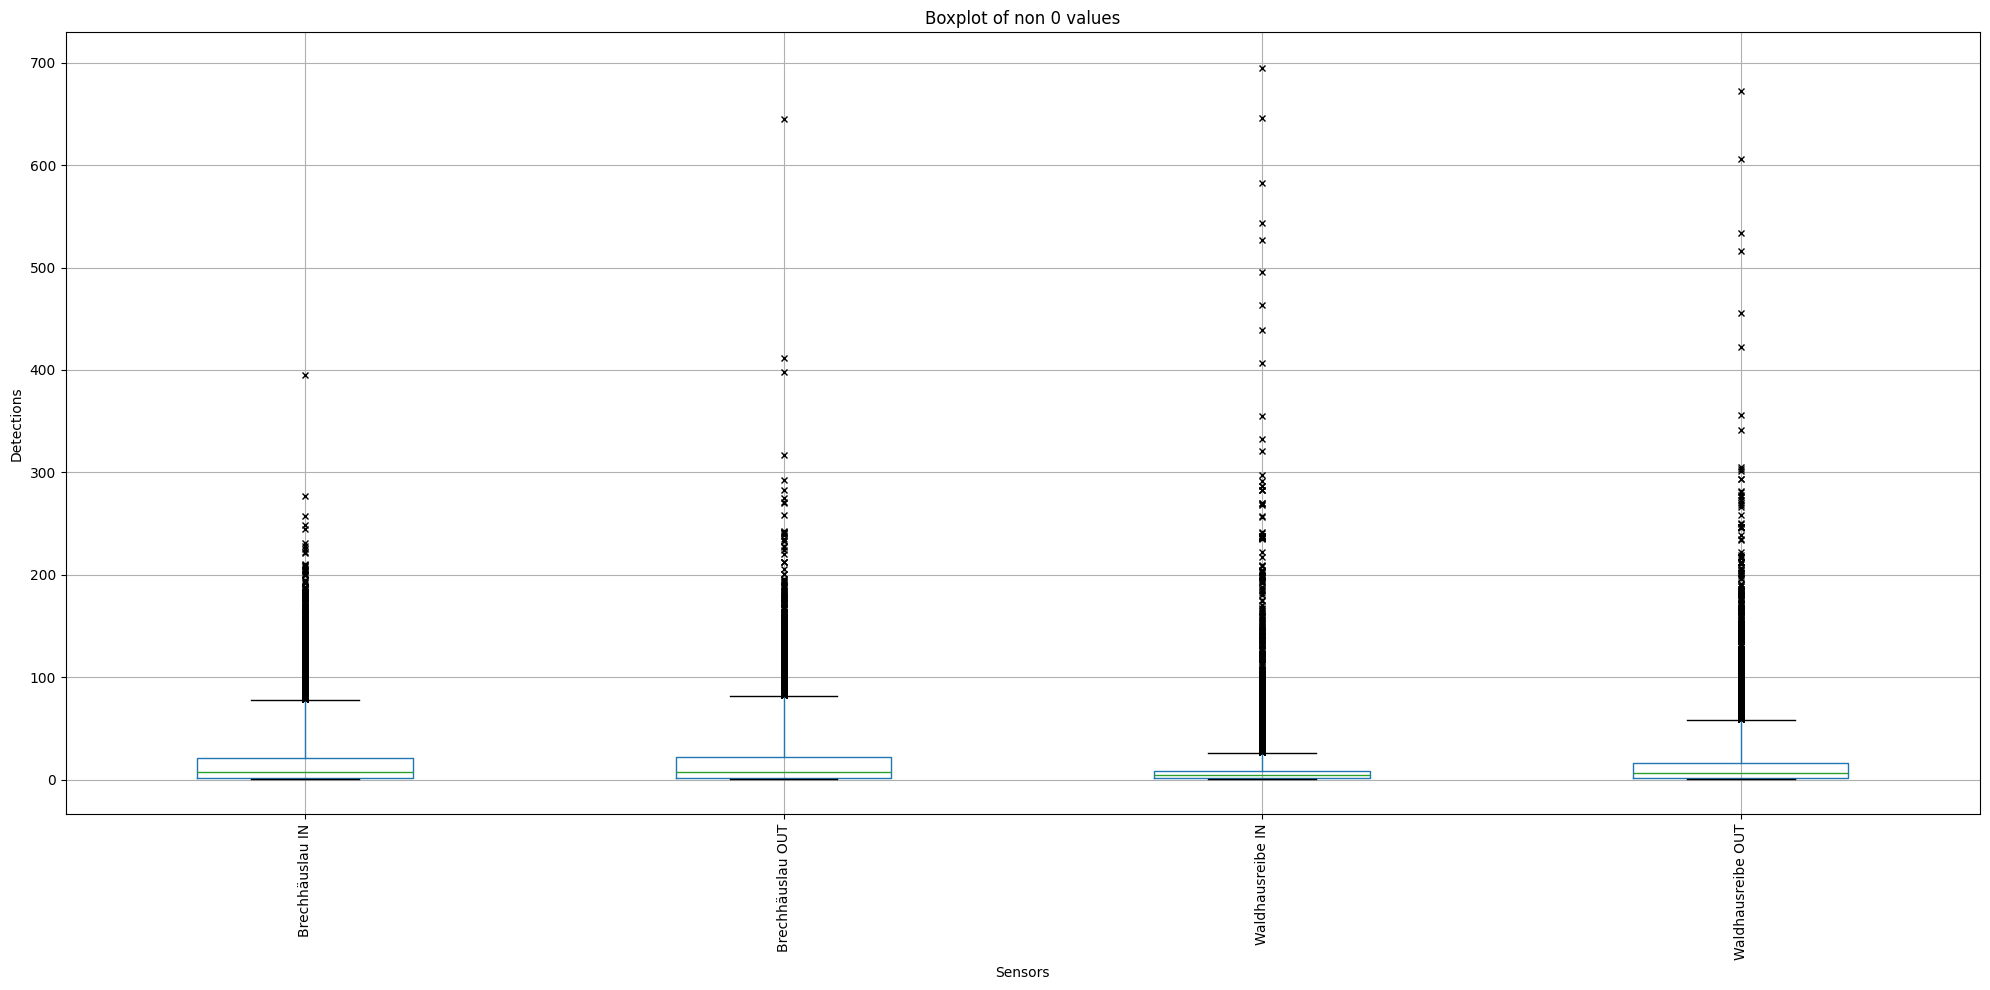

In [ ]:
# Replace zero values with NaN to better visualize boxplots
df_filtered = df[['Brechhäuslau IN', 'Brechhäuslau OUT', 'Waldhausreibe IN',	'Waldhausreibe OUT']].replace(0, np.nan)

# Drop rows where all values are NaN (i.e., where all values were zero or greater than 1000)
df_filtered = df_filtered.dropna(how='all')

# Drop columns where all values are NaN (if any column became completely empty)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Check if there are any remaining columns to plot
if not df_filtered.empty and not df_filtered.select_dtypes(include=[np.number]).empty:
    plt.figure(figsize=(20, 10))
    
    # Create the boxplot
    boxplot = df_filtered.boxplot(
        whis=3,
        flierprops=dict(marker='x', color='red', markersize=5)
    )
    
    plt.title('Boxplot of non 0 values')
    plt.xlabel('Sensors')
    plt.ylabel('Detections')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
else:
    print("No numeric columns available for plotting.")

In [ ]:
# Create a DataFrame for 'IN' sensors
in_sums = df_merged[traffic_columns].filter(like='IN').sum().reset_index()
in_sums.columns = ['Sensor', 'Total_Count']
in_sums['Sensor'] = in_sums['Sensor'].str.replace(' IN', '')
in_sums['Direction'] = 'IN'

# Create a DataFrame for 'OUT' sensors
out_sums = df_merged[traffic_columns].filter(like='OUT').sum().reset_index()
out_sums.columns = ['Sensor', 'Total_Count']
out_sums['Sensor'] = out_sums['Sensor'].str.replace(' OUT', '')
out_sums['Direction'] = 'OUT'

# Combine the 'IN' and 'OUT' DataFrames
result_df = pd.concat([in_sums, out_sums])

# Reset the index to have a clean DataFrame
result_df.set_index(['Sensor', 'Direction'], inplace=True)



In [ ]:
result_df.groupby("Direction").sum()

Total_Count
Direction             
IN           2849460.0
OUT          2868249.0

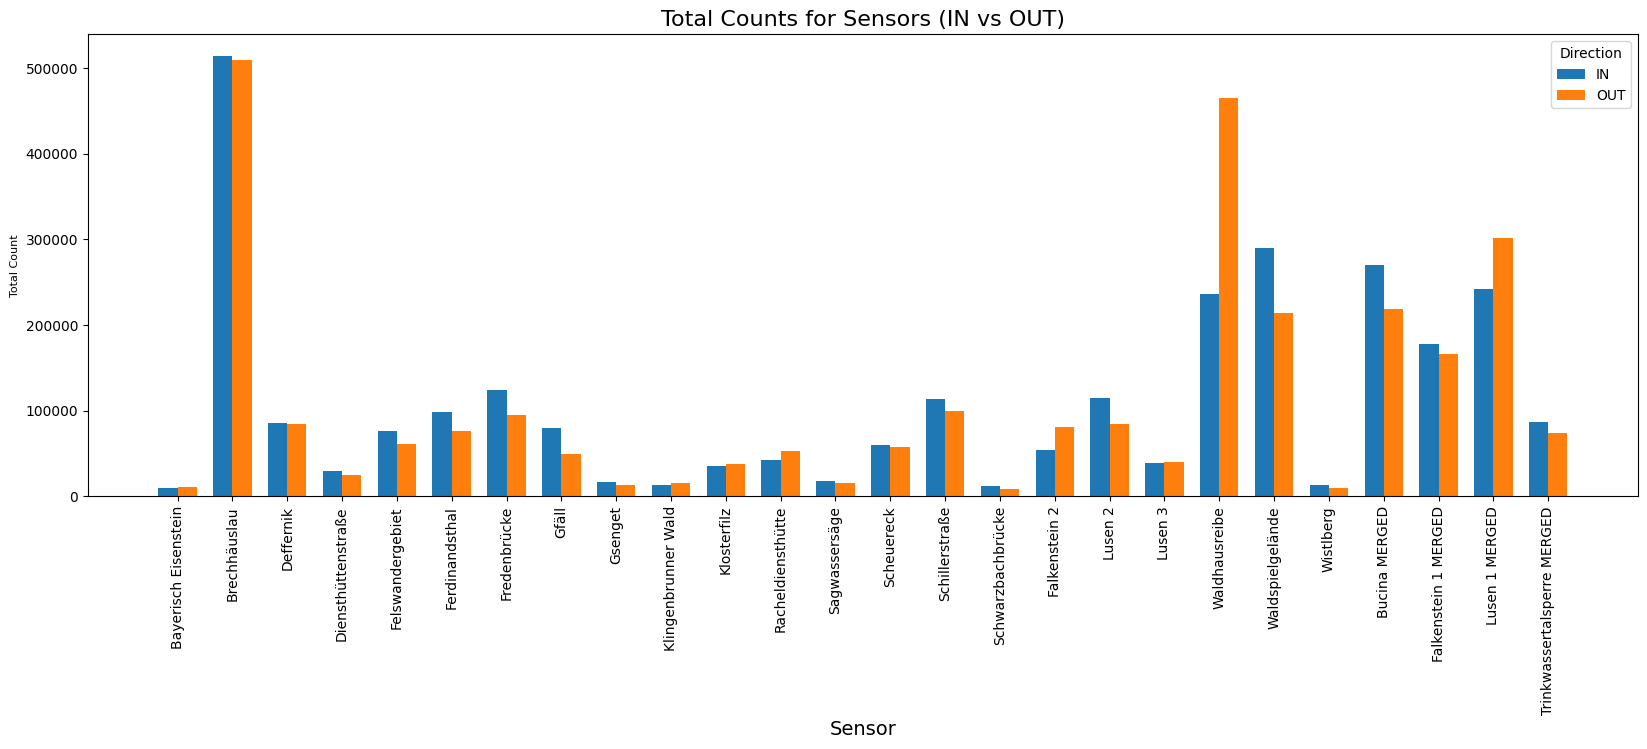

In [ ]:
# Reset the index to get 'Sensor' and 'Direction' as columns for easier plotting
df_plot = result_df.reset_index()

# Get unique sensor names and directions
sensors = df_plot['Sensor'].unique()
directions = df_plot['Direction'].unique()

# Set up the positions and width for the bars
x = np.arange(len(sensors))
width = 0.35  # Width of the bars

# Split the data for IN and OUT
in_counts = df_plot[df_plot['Direction'] == 'IN']['Total_Count']
out_counts = df_plot[df_plot['Direction'] == 'OUT']['Total_Count']

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(x - width/2, in_counts, width, label='IN')
plt.bar(x + width/2, out_counts, width, label='OUT')

# Adding titles and labels
plt.title('Total Counts for Sensors (IN vs OUT)', fontsize=16)
plt.xlabel('Sensor', fontsize=14)
plt.ylabel('Total Count', fontsize=8)
plt.xticks(x, sensors, rotation=90, fontsize=10)  # Set x-ticks with sensor names and rotate for better readability
plt.legend(title='Direction')

# Show plot
#plt.tight_layout()
plt.show()

COUNT OF SENSORS AT NIGHT

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (28,) and arg 1 with shape (27,).

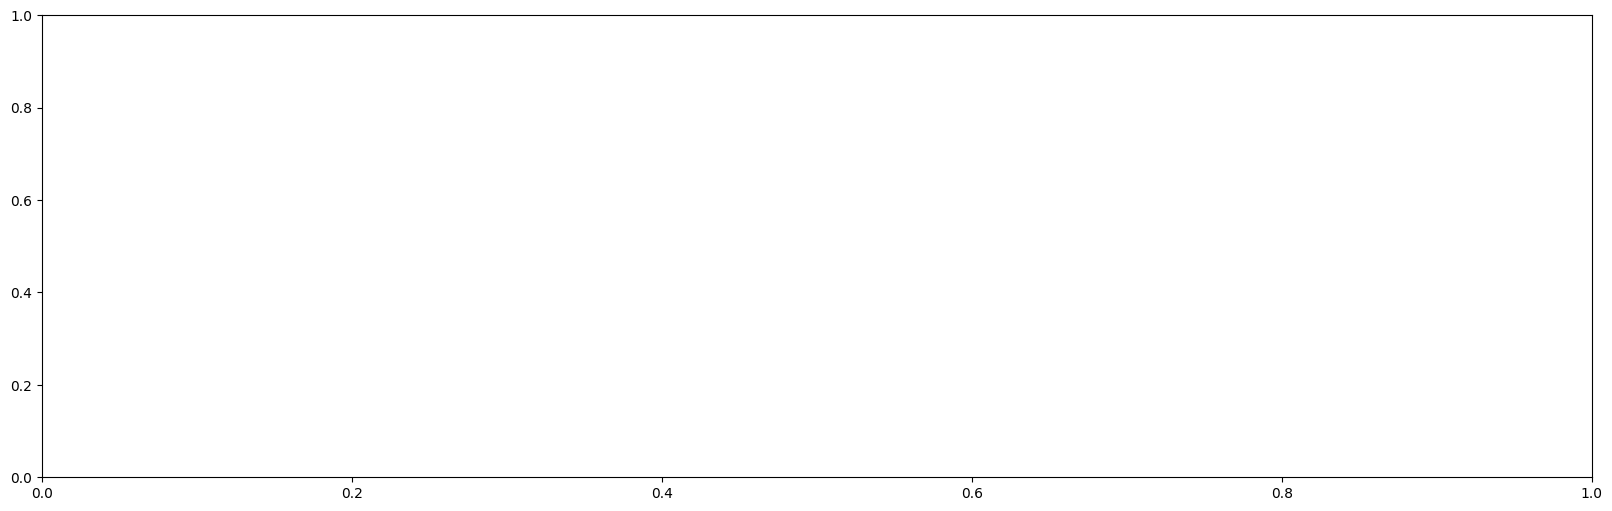

In [ ]:
times = df_merged.index.time
# Define time ranges
start_time = pd.to_datetime('23:00:00').time()
end_time = pd.to_datetime('05:00:00').time()

# Filter rows where time is between 23:00:00 and 05:00:00
mask = (times >= start_time) | (times <= end_time)
df_filtered = df_merged[mask]

# Create a DataFrame for 'IN' sensors
in_sums = df_filtered.filter(like='IN').sum().reset_index()
in_sums.columns = ['Sensor', 'Total_Count']
in_sums['Sensor'] = in_sums['Sensor'].str.replace(' IN', '')
in_sums['Direction'] = 'IN'

# Create a DataFrame for 'OUT' sensors
out_sums = df_filtered.filter(like='OUT').sum().reset_index()
out_sums.columns = ['Sensor', 'Total_Count']
out_sums['Sensor'] = out_sums['Sensor'].str.replace(' OUT', '')
out_sums['Direction'] = 'OUT'

# Combine the 'IN' and 'OUT' DataFrames
result_df = pd.concat([in_sums, out_sums])

# Reset the index to have a clean DataFrame
result_df.set_index(['Sensor', 'Direction'], inplace=True)

# Reset the index to get 'Sensor' and 'Direction' as columns for easier plotting
df_plot = result_df.reset_index()

# Get unique sensor names and directions
sensors = df_plot['Sensor'].unique()
directions = df_plot['Direction'].unique()

# Set up the positions and width for the bars
x = np.arange(len(sensors))
width = 0.35  # Width of the bars

# Split the data for IN and OUT
in_counts = df_plot[df_plot['Direction'] == 'IN']['Total_Count']
out_counts = df_plot[df_plot['Direction'] == 'OUT']['Total_Count']

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(x - width/2, in_counts, width, label='IN')
plt.bar(x + width/2, out_counts, width, label='OUT')

# Adding titles and labels
plt.title('Total Counts for Sensors between 23:00 and 05:00', fontsize=16)
plt.xlabel('Sensor', fontsize=14)
plt.ylabel('Total Count', fontsize=8)
plt.xticks(x, sensors, rotation=90, fontsize=10)  # Set x-ticks with sensor names and rotate for better readability
plt.legend(title='Direction')

# Show plot
#plt.tight_layout()
plt.show()